# Определение возраста покупателей по фотографии

**Заголовок:** Определение возраста покупателей по фотографии

**Описание проекта:** Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

**Критерии, которые важны заказчику:**
Значение метрики *MAE* на тестовой выборке не больше 8

**Цель исследования:** 
* Постройте модель, которая по фотографии определит приблизительный возраст человека.

**Ход исследования:**
* Загрузка датасета
* Исследовательский анализ данных
* Формирование архитектуры обучаемой модели
* Обучение модели в облаке с помощью GPU
* Формирование выводом по результатам обучения модели

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов

# Исследовательский анализ данных

## Знакомство с датафреймом

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузка датасета
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# Вывод первых строк датасета
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# Описательная статистика по таргету
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

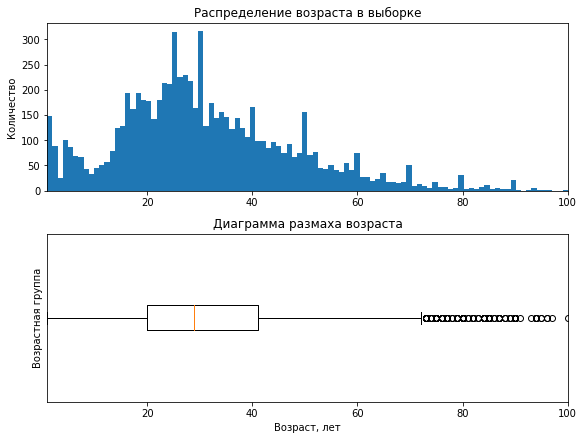

In [37]:
# Задаем размер графика и их количество
fig, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)

# Задаем одинаковую размерность данных по оси X
xmin, xmax = df['real_age'].min(), df['real_age'].max()

# Гистограмма и подписи
axes[0].hist(df['real_age'], bins=100)
axes[0].set_xlim(xmin, xmax)
axes[0].set_title('Распределение возраста в выборке')
axes[0].set_ylabel('Количество')

# Ящик с усами и подписи
axes[1].boxplot(df['real_age'], vert=False)
axes[1].set_xlim(xmin, xmax)
axes[1].set_title('Диаграмма размаха возраста')
axes[1].set_xlabel('Возраст, лет')
axes[1].set_ylabel('Возрастная группа')

# Убираем автоматическую категорию "1"
axes[1].set_yticks([])

# Выводим график
plt.show()

In [7]:
# Мода выборки
mode_value = df['real_age'].mode()[0]
print("Мода возраста:", mode_value)

Мода возраста: 30


In [8]:
# Инициализация генератора
datagen = ImageDataGenerator(rescale=1./255)

# Загрузка потока изображений
datagen_flow = datagen.flow_from_dataframe(dataframe=df, 
                                           directory='/datasets/faces/final_files',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224,224),
                                           batch_size=16,
                                           class_mode='raw',
                                           seed=12345)

# Вывод информации о фичах
images, ages = next(datagen_flow)
print(images.shape, ages[:10])

Found 7591 validated image filenames.
(16, 224, 224, 3) [50 41 46 85 14 40 14 53  4 32]


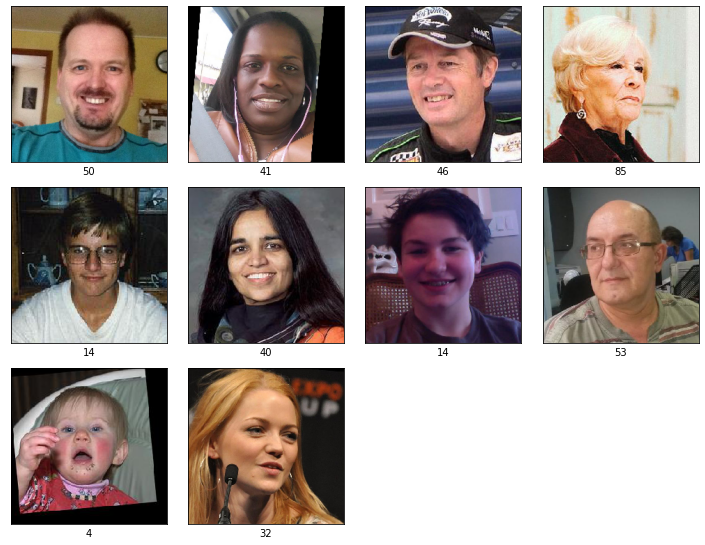

In [16]:
# Печать нескольких изображений
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.xlabel(ages[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Промежуточные выводы

* В датасете 7.6 тыс. изображений - такой объём выборки подойдёт для небольшой нейросети
* Типы данных в датасете указаны корректно
* Распределение возраста в выборке показало медиану - 29 лет, моду - 30 лет
* Такое распределение возраста говорит о том, что выборка смещена в сторону возрастной группы 25–35 лет, из-за чего модель может быть склонна предсказывать возраст именно в этом диапазоне
* На фотографиях разный фон, лица имеют разную ориентацию (некоторые смотрят влево, некоторые вправо, некоторые - прямо), где-то встречается поворот фото под углом
* На фотографиях встречаются различные условия съёмки: разный фон, различная ориентация лица (влево, вправо, прямо), а также наклоны и повороты изображений.
* Такая вариативность увеличивает неоднородность признаков, что потенциально усложняет обучение модели
* Модель должна научиться быть инвариантной к поворотам и наклонам головы, чтобы корректно обрабатывать разные ракурсы
* Для повышения устойчивости модели необходимо применить аугментации, включая повороты, отражения и изменения освещения

# Обучение модели

## Код для обучения модели

### Загрузка тренировочной выборки

In [10]:
def load_train(path):
    """
    Загружает тренировочную часть выборки и формирует генератор данных
    для обучения модели.

    Функция:
    - считывает файл labels.csv из директории `path`;
    - создаёт ImageDataGenerator, выполняющий нормализацию изображений и 
      лёгкие аугментации, а также отвечающий за разбиение выборки на обучающую
      и валидационную части через параметр validation_split;
    - формирует поток изображений и соответствующих целевых значений (возраста)
      для использования в процессе обучения модели.

    Параметры:
        path (str): Путь к директории, содержащей файл `labels.csv` и папку 
                    `/final_files` с изображениями.

    Возвращает:
        train_datagen_flow (Iterator): Генератор обучающих данных (DataFrameIterator),
                                       используемый в методе `model.fit()` как train_data.
    """
    # Читаем датафрейм
    df = pd.read_csv(path + 'labels.csv')
    
    # Инициализация генератора изображений с нормализацией и агументацией
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       validation_split=0.25,
                                       rotation_range=10
                                       )
    
    # Читаем поток изображений из источника и соотносим фичи и таргет с датафреймом
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df, 
                                           directory=path + '/final_files',
                                           subset='training',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224,224),
                                           batch_size=16,
                                           class_mode='raw',
                                           seed=12345)
    
    return train_datagen_flow

### Загрузка тестовой выборки

In [11]:
def load_test(path):
    """
    Загружает валидационную (тестовую) выборку изображений и формирует генератор данных
    для оценки качества модели.

    Функция:
    - считывает файл labels.csv из указанной директории;
    - использует ImageDataGenerator для нормализации изображений и разделения выборки
      на обучающую и валидационную части через параметр validation_split;
    - создаёт поток данных (DataFrameIterator) для валидационной части выборки,
      сопоставляя имена файлов с изображениями и их целевыми значениями (возрастом).

    Параметры:
        path (str): Путь к директории, содержащей `labels.csv` и папку `/final_files` 
                    с изображениями.

    Возвращает:
        test_datagen_flow (Iterator): Генератор изображений и возрастов для валидационной
                                      выборки, готовый для использования в `model.evaluate`
                                      или `model.fit` как validation_data.
    """
    # Читаем датафрейм
    df = pd.read_csv(path + 'labels.csv')
    
    # Инициализация генератора изображений с нормализацией
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Читаем поток изображений из источника и соотносим фичи и таргет с датафреймом
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                           directory=path + '/final_files',
                                           subset='validation',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224,224),
                                           batch_size=16,
                                           class_mode='raw',
                                           seed=12345)
    
    return test_datagen_flow

### Формирование архитектуры модели

In [12]:
def create_model(input_shape):
    """
    Создаёт архитектуру модели для регрессии возраста на основе предобученной ResNet50.

    Параметры:
        input_shape (tuple): Размер входного изображения (H, W, C).

    Модель включает:
    - загрузку предобученной ResNet50 без верхних слоев (include_top=False),
    - глобальный усредняющий пулинг,
    - финальный полносвязный слой для предсказания возраста (Dense(1)),
    - компиляцию с loss='mse' и метрикой 'mae'.

    Возвращает:
        model (keras.Model): скомпилированная модель, готовая к обучению.
    """
    # Загружаем модель и веса
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    # Активируем режим обучения
    backbone.trainable = True

    # Формируем обучаемые слои
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    
    # Компилируем модель, указываем оптимизатор, функцию потерь mse, метрику оценки mae
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mse',
                  metrics=['mae'])

    return model

### Обучение модели

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    """
    Обучает модель на тренировочной выборке и оценивает её качество
    на валидационной выборке.

    Функция выполняет полный цикл обучения модели с использованием генераторов
    данных. В процессе обучения выводятся значения функции потерь и метрик как
    на тренировочной, так и на валидационной выборке.

    Параметры:
        model (keras.Model): Скомпилированная нейронная сеть, готовая к обучению.
        train_data (Iterator): Генератор обучающих данных (например, DataFrameIterator).
        test_data (Iterator): Генератор данных для валидации модели.
        batch_size (int, optional): Размер батча. Обычно None при использовании генераторов.
        epochs (int): Количество эпох обучения.
        steps_per_epoch (int, optional): Число шагов на эпоху. Если None — берётся автоматически.
        validation_steps (int, optional): Количество шагов валидации. Если None — определяется автоматически.

    Возвращает:
        model (keras.Model): Обученная модель с обновлёнными весами.
    """
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Результаты обучения и инференса модели

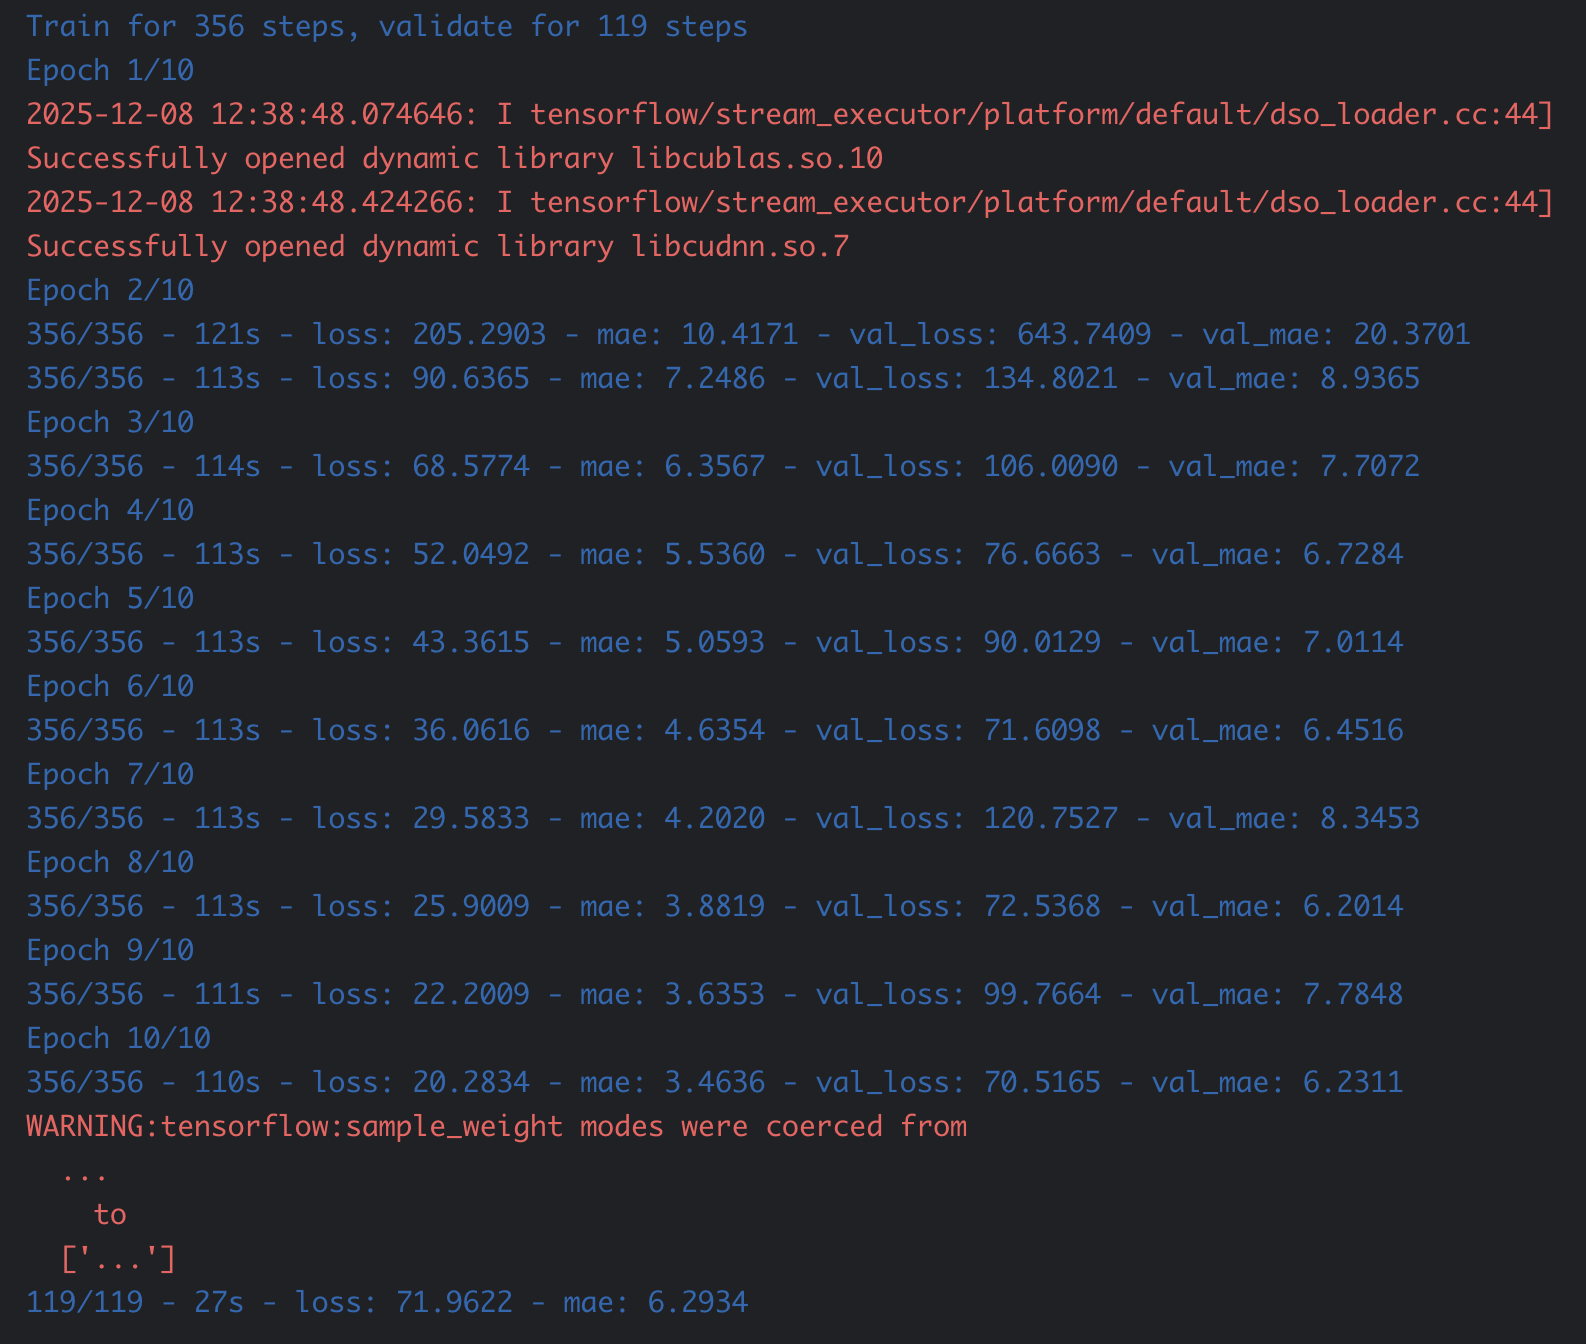

## Выводы по результатам работы модели

* Для обучения была выбрана архитектура **ResNet50**, поскольку предобученные глубокие свёрточные сети хорошо подходят для извлечения универсальных признаков и обеспечивают высокое качество в задачах регресссии возраста.

* В качестве функции потерь использована **MSE (среднеквадратичная ошибка)**, поскольку она сильнее штрафует большие отклонения и способствует снижению крупных ошибок в предсказаниях возраста.

* Метрикой качества выбрана **MAE**, так как она напрямую интерпретируется в годах и позволяет легко оценивать практическую точность модели (в отличие от MSE, где пришлось бы извлекать квадратный корень).

* На ранних этапах были протестированы варианты **разморозки слоёв ResNet50**, однако они не привели к улучшению метрик, и итоговая версия обучена без глубокого fine-tuning.

* Генератор изображений включает нормализацию, изменение разрешения входных изображений, а также лёгкие аугментации (горизонтальный флип и поворот на 10°), что повышает устойчивость модели к вариациям ориентации лица.

* Обучение модели проводилось на протяжении **10 эпох**.

* Итоговые результаты:

  * **MAE на обучающей выборке:** 3.5
  * **MAE на валидационной выборке:** 6.2
  * **MAE на тестовой выборке:** 6.3

* Наблюдается элемент переобучения (разрыв между обучением и валидацией), что типично для глубоких архитектур при обучении на сравнительно небольшом датасете.

* **Целевая метрика (MAE ≤ 8)** успешно достигнута.